# How to load PDFs

[Portable Document Format (PDF)](https://en.wikipedia.org/wiki/PDF), standardized as ISO 32000, is a file format developed by Adobe in 1992 to present documents, including text formatting and images, in a manner independent of application software, hardware, and operating systems.

This guide covers how to [load](/docs/concepts/document_loaders/) `PDF` documents into the LangChain [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) format that we use downstream.

Text in PDFs is typically represented via text boxes. They may also contain images. A PDF parser might do some combination of the following:

- Agglomerate text boxes into lines, paragraphs, and other structures via heuristics or ML inference;
- Run [OCR](https://en.wikipedia.org/wiki/Optical_character_recognition) on images to detect text therein;
- Classify text as belonging to paragraphs, lists, tables, or other structures;
- Structure text into table rows and columns, or key-value pairs.

LangChain integrates with a host of PDF parsers. Some are simple and relatively low-level; others will support OCR and image-processing, or perform advanced document layout analysis. The right choice will depend on your needs. Below we enumerate the possibilities.

We will demonstrate these approaches on a [sample file](https://github.com/langchain-ai/langchain/blob/master/libs/community/tests/integration_tests/examples/layout-parser-paper.pdf):

In [1]:
file_path = (
    "/CSE Module Handbook.pdf"
)

:::info A note on multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications -- such as question-answering over PDFs with complex layouts, diagrams, or scans -- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. We demonstrate an example of this in the [Use of multimodal models](/docs/how_to/document_loader_pdf/#use-of-multimodal-models) section below.

:::

## Simple and fast text extraction

If you are looking for a simple string representation of text that is embedded in a PDF, the method below is appropriate. It will return a list of [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects-- one per page-- containing a single string of the page's text in the Document's `page_content` attribute. It will not parse text in images or scanned PDF pages. Under the hood it uses the [pypdf](https://pypdf.readthedocs.io/en/stable/) Python library.

LangChain [document loaders](/docs/concepts/document_loaders) implement `lazy_load` and its async variant, `alazy_load`, which return iterators of `Document` objects. We will use these below.

In [4]:
!pip install -qU langchain-google-genai
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.16 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


In [2]:
%pip install -qU pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.8 MB/s eta 0:00:00


In [5]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [6]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'Foxit Reader PDF Printer Version 8.0.2.0718', 'creator': '', 'creationdate': '2021-07-14T11:48:09+07:00', 'author': '', 'keywords': '', 'moddate': '2021-07-14T12:09:23+07:00', 'subject': '', 'title': '', 'source': '/CSE Module Handbook.pdf', 'total_pages': 108, 'page': 0, 'page_label': '1'}

F
aculty of Engineering 
MOD
ULE HANDBOOK 
Bac
helor’s Program in Computer Science 
In accordance with the specific examination regulation of 
the bachelor’s program in Computer Science 
Annex B


Note that the metadata of each document stores the corresponding page number.

### Vector search over PDFs

Once we have loaded PDFs into LangChain `Document` objects, we can index them (e.g., a RAG application) in the usual way. Below we use OpenAI embeddings, although any LangChain [embeddings](https://python.langchain.com/docs/concepts/embedding_models) model will suffice.

In [13]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-thinking-exp-01-21",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [16]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

vector_store = InMemoryVectorStore.from_documents(pages, embeddings)
docs = vector_store.similarity_search("What is LayoutParser?", k=2)
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 61: 62
 
 
Contents
 
 
No.
 
Topic
 
1.
 
Software design 
concepts. Modularity. Object
-
oriented design concepts.
 
2.
 
Architectural design. Architectural styles. Architectural design for Web Apps and 
Mobile Apps.
 
3.
 
Component
-
level design. Design principles. Cohesion. Coupling. Design for r

Page 50: 51
 
 
Contents
 
No.
 
Topic
 
1.
 
 
Constructs of the object
-
oriented programming, in particular the programming 
language Java
 
2.
 
 
Platform
-
independent specif
ication
 
3.
 
 
Design and implementation of applications with a dialog interface using at least one 
pre
-
assembled class lib



## Layout analysis and extraction of text from images

If you require a more granular segmentation of text (e.g., into distinct paragraphs, titles, tables, or other structures) or require extraction of text from images, the method below is appropriate. It will return a list of [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects, where each object represents a structure on the page. The Document's metadata stores the page number and other information related to the object (e.g., it might store table rows and columns in the case of a table object).

Under the hood it uses the `langchain-unstructured` library. See the [integration docs](/docs/integrations/document_loaders/unstructured_file/) for more information about using [Unstructured](https://docs.unstructured.io/welcome) with LangChain.

Unstructured supports multiple parameters for PDF parsing:
- `strategy` (e.g., `"fast"` or `"hi-res"`)
- API or local processing. You will need an API key to use the API.

The [hi-res](https://docs.unstructured.io/api-reference/how-to/choose-hi-res-model) strategy provides support for document layout analysis and OCR. We demonstrate it below via the API. See [local parsing](/docs/how_to/document_loader_pdf/#local-parsing) section below for considerations when running locally.

In [17]:
%pip install -qU langchain-unstructured

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.8/166.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00


In [37]:
import getpass
import os

os.environ["UNSTRUCTURED_API_KEY"] = userdata.get('UNSTRUCTURED_API_KEY')

As before, we initialize a loader and load documents lazily:

In [38]:
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,
    coordinates=True,
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

Here we recover 171 distinct structures over the 16 page document:

In [39]:
print(len(docs))

1758


We can use the document metadata to recover content from a single page:

In [40]:
first_page_docs = [doc for doc in docs if doc.metadata.get("page_number") == 1]

for doc in first_page_docs:
    print(doc.page_content)


Vietnamese-German University
Faculty of Engineering
Annex B
MODULE HANDBOOK
Bachelor’s Program in Computer Science
In accordance with the specific examination regulation of the bachelor’s program in Computer Science


### Extracting tables and other structures

Each `Document` we load represents a structure, like a title, paragraph, or table.

Some structures may be of special interest for indexing or question-answering tasks. These structures may be:
1. Classified for easy identification;
2. Parsed into a more structured representation.

Below, we identify and extract a table:

<details>
<summary>Click to expand code for rendering pages</summary>

In [42]:
%pip install -qU matplotlib PyMuPDF pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 35.0 MB/s eta 0:00:00


In [43]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

</details>

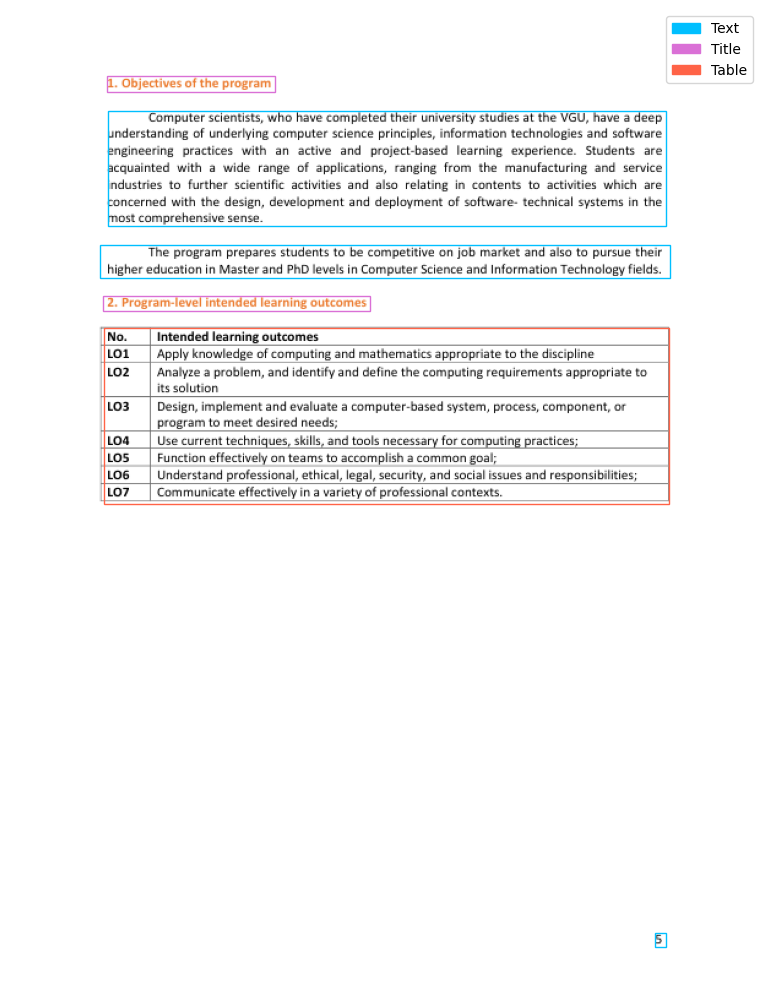

1. Objectives of the program

Computer scientists, who have completed their university studies at the VGU, have a deep understanding of underlying computer science principles, information technologies and software engineering practices with an active and project-based learning experience. Students are acquainted with a wide range of applications, ranging from the manufacturing and service industries to further scientific activities and also relating in contents to activities which are concerned with the design, development and deployment of software- technical systems in the most comprehensive sense.

The program prepares students to be competitive on job market and also to pursue their higher education in Master and PhD levels in Computer Science and Information Technology fields.

2. Program-level intended learning outcomes

No. Intended learning outcomes LO1 Apply knowledge of computing and mathematics appropriate to the discipline LO2 Analyze a problem, and identify and define the 

In [44]:
render_page(docs, 5)

Note that although the table text is collapsed into a single string in the document's content, the metadata contains a representation of its rows and columns:

In [45]:
from IPython.display import HTML, display

segments = [
    doc.metadata
    for doc in docs
    if doc.metadata.get("page_number") == 5 and doc.metadata.get("category") == "Table"
]

display(HTML(segments[0]["text_as_html"]))

No,Intended learning outcomes
LO1,Apply knowledge of computing and mathematics appropriate to the discipline
LO2,"Analyze a problem, and identify and define the computing requirements appropriate to its solution"
LO3,"Design, implement and evaluate a computer-based system, process, component, or program to meet desired needs;"
LO4,"Use current techniques, skills, and tools necessary for computing practices;"
LO5,Function effectively on teams to accomplish a common goal;
LO6,"Understand professional, ethical, legal, security, and social issues and responsibilities;"
LO7,Communicate effectively in a variety of professional contexts.


<table><thead><tr><th colspan="3">able 1. LUllclll 1ayoul actCCLloll 1110AdCs 111 L1C LayoOulralsel 1110U4cl 200</th></tr><tr><th>Dataset</th><th>| Base Model\'|</th><th>Notes</th></tr></thead><tbody><tr><td>PubLayNet [38]</td><td>F/M</td><td>Layouts of modern scientific documents</td></tr><tr><td>PRImA</td><td>M</td><td>Layouts of scanned modern magazines and scientific reports</td></tr><tr><td>Newspaper</td><td>F</td><td>Layouts of scanned US newspapers from the 20th century</td></tr><tr><td>TableBank [18]</td><td>F</td><td>Table region on modern scientific and business document</td></tr><tr><td>HJDataset</td><td>F/M</td><td>Layouts of history Japanese documents</td></tr></tbody></table>

### Extracting text from specific sections

Structures may have parent-child relationships -- for example, a paragraph might belong to a section with a title. If a section is of particular interest (e.g., for indexing) we can isolate the corresponding `Document` objects.

Below, we extract all text associated with the document's "Conclusion" section:

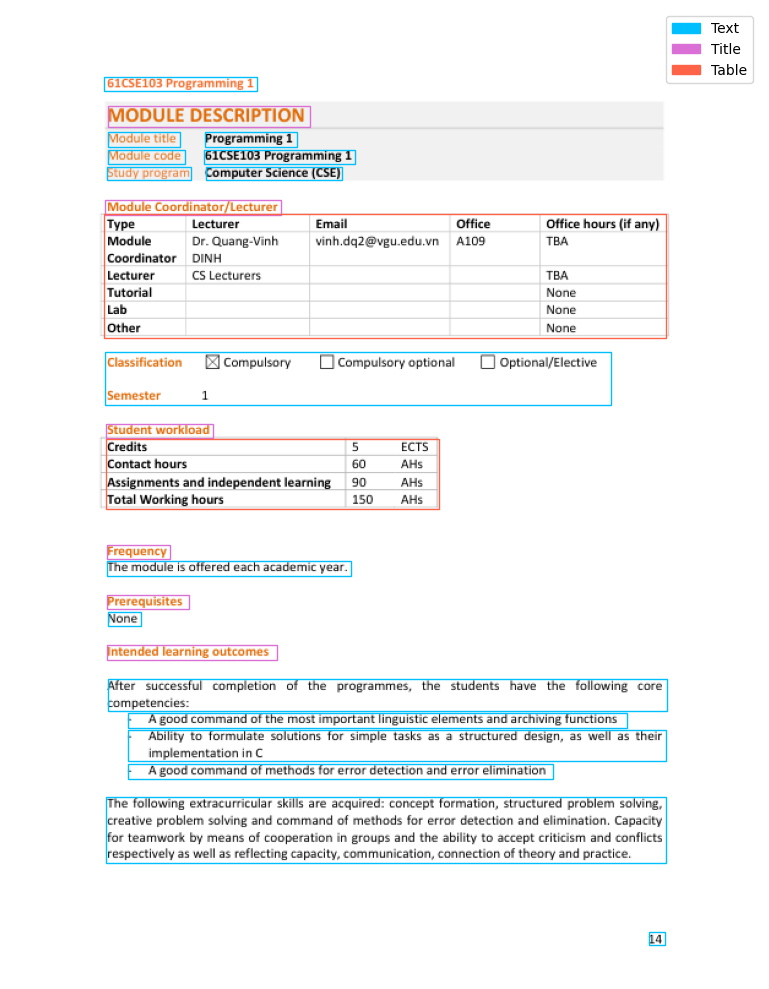

In [46]:
render_page(docs, 14, print_text=False)

In [47]:
conclusion_docs = []
parent_id = -1
for doc in docs:
    if doc.metadata["category"] == "Title" and "Conclusion" in doc.page_content:
        parent_id = doc.metadata["element_id"]
    if doc.metadata.get("parent_id") == parent_id:
        conclusion_docs.append(doc)

for doc in conclusion_docs:
    print(doc.page_content)

### Extracting text from images

OCR is run on images, enabling the extraction of text therein:

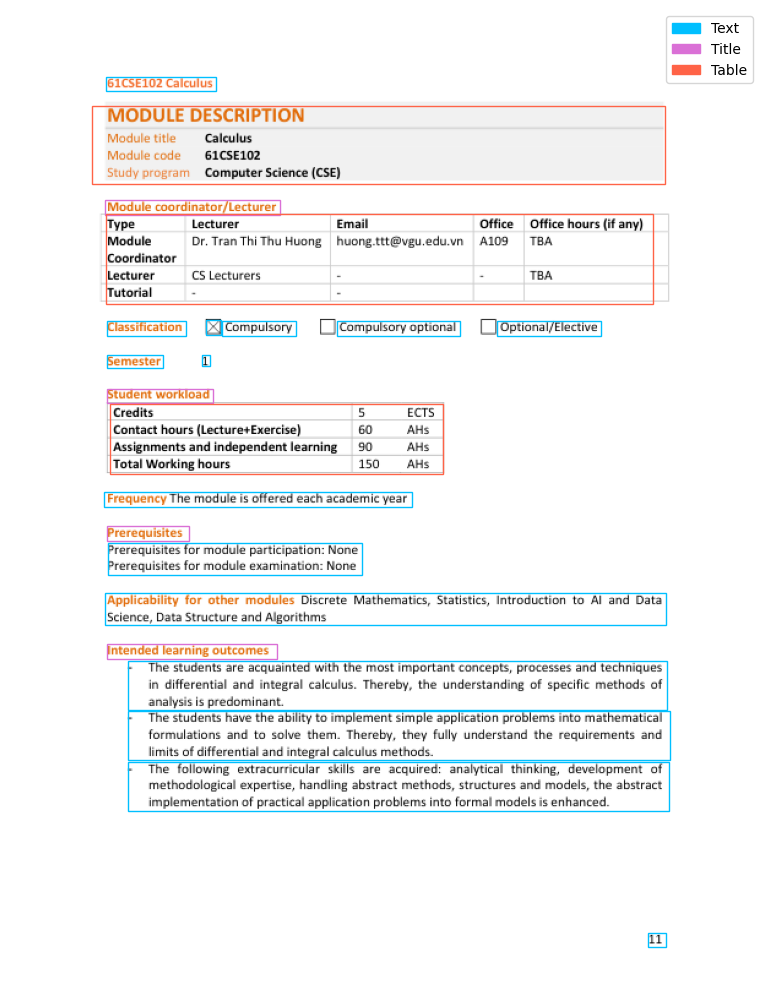

61CSE102 Calculus

MODULE DESCRIPTION Module title Calculus Module code 61CSE102 Study program Computer Science (CSE)

Module coordinator/Lecturer

Type Lecturer Email Office Office hours (if any) Module Dr. Tran Thi Thu Huong huong.ttt@vgu.edu.vn A109 TBA Coordinator Lecturer CS Lecturers - - TBA Tutorial - -

Classification

|

Compulsory

Compulsory optional

Optional/Elective

Semester

1

Student workload

Credits 5 ECTS Contact hours (Lecture+Exercise) 60 AHs Assignments and independent learning 90 AHs Total Working hours 150 AHs

Frequency The module is offered each academic year

Prerequisites

Prerequisites for module participation: None Prerequisites for module examination: None

Applicability for other modules Discrete Mathematics, Statistics, Introduction to AI and Data Science, Data Structure and Algorithms

Intended learning outcomes

- The students are acquainted with the most important concepts, processes and techniques in differential and integral calculus. Thereby, th

In [48]:
render_page(docs, 11)

Note that the text from the figure on the right is extracted and incorporated into the content of the `Document`.

### Local parsing

Parsing locally requires the installation of additional dependencies.

**Poppler** (PDF analysis)
- Linux: `apt-get install poppler-utils`
- Mac: `brew install poppler`
- Windows: https://github.com/oschwartz10612/poppler-windows

**Tesseract** (OCR)
- Linux: `apt-get install tesseract-ocr`
- Mac: `brew install tesseract`
- Windows: https://github.com/UB-Mannheim/tesseract/wiki#tesseract-installer-for-windows

We will also need to install the `unstructured` PDF extras:

In [49]:
%pip install -qU "unstructured[pdf]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.4/523.4 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We can then use the [UnstructuredLoader](https://python.langchain.com/api_reference/unstructured/document_loaders/langchain_unstructured.document_loaders.UnstructuredLoader.html) much the same way, forgoing the API key and `partition_via_api` setting:

In [52]:
!apt-get install poppler-utils # Install poppler-utils if you have not installed previously.
import os
os.environ['PATH'] += os.pathsep + '/usr/bin'  # Add '/usr/bin' to PATH

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (214 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [1]:
loader_local = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
)
docs_local = []
for doc in loader_local.lazy_load():
    docs_local.append(doc)

NameError: name 'UnstructuredLoader' is not defined

The list of documents can then be processed similarly to those obtained from the API.

## Use of multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications-- such as question-answering over PDFs with complex layouts, diagrams, or scans-- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. This allows a model to reason over the two dimensional content on the page, instead of a "one-dimensional" string representation.

In principle we can use any LangChain [chat model](/docs/concepts/chat_models) that supports multimodal inputs. A list of these models is documented [here](/docs/integrations/chat/). Below we use OpenAI's `gpt-4o-mini`.

First we define a short utility function to convert a PDF page to a base64-encoded image:

In [ ]:
%pip install -qU PyMuPDF pillow langchain-openai

In [ ]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

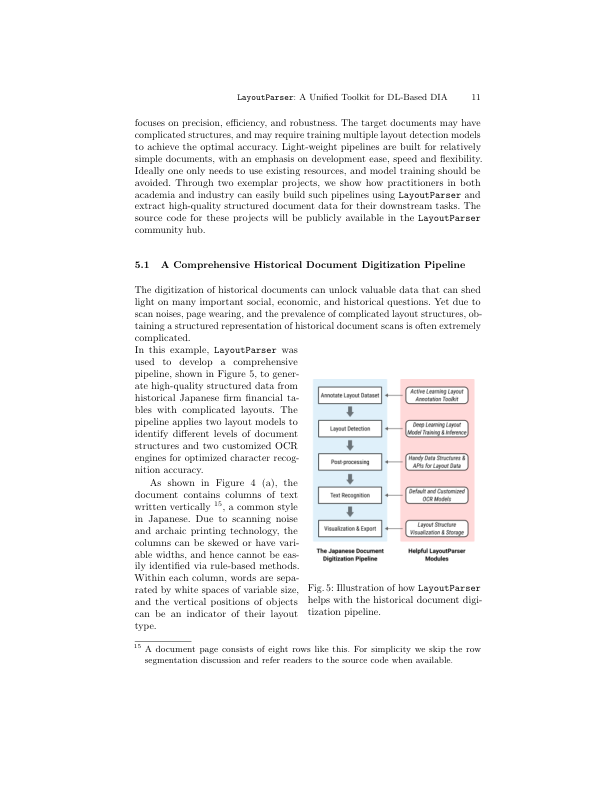

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 11)
display(IPImage(data=base64.b64decode(base64_image)))

We can then query the model in the [usual way](/docs/how_to/multimodal_inputs/). Below we ask it a question on related to the diagram on the page.

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
from langchain_core.messages import HumanMessage

query = "What is the name of the first step in the pipeline?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The first step in the pipeline is "Annotate Layout Dataset."


## Other PDF loaders

For a list of available LangChain PDF loaders, please see [this table](/docs/integrations/document_loaders/#pdfs).